# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [2]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = sid.polarity_scores(for_sentiment)

for k in ss:
    print('{0}: {1}, '.format(k, ss[k]), end='')

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
neg: 0.01, neu: 0.745, pos: 0.245, compound: 0.9975, 

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


<h1>1. GBDT (xgboost/lightgbm) </h1>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from sklearn.naive_bayes import MultinomialNB
import pickle
from tqdm import tqdm
import os


## 1.1 Loading Data

In [5]:
data = pd.read_csv('/content/drive/MyDrive/preprocessed_data.csv',nrows=55000)

In [7]:
data1=pd.read_csv("/content/drive/MyDrive/project_data.csv",nrows=55000)

In [8]:
data["Title"]=data1["project_title"]

In [9]:
data=data[["school_state","teacher_prefix","essay","project_grade_category","clean_categories","clean_subcategories","price","teacher_number_of_previously_posted_projects","project_is_approved","Title"]]

Removing class imbalance

In [10]:
from sklearn.utils import resample

In [11]:
df_majority=data[data.project_is_approved==1]
df_minority=data[data.project_is_approved==0]

In [12]:
df_minority_upsampled = resample(df_minority, replace=True,n_samples=len(df_majority))

In [13]:
data = pd.concat([df_majority, df_minority_upsampled])

In [14]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)

,school_state,teacher_prefix,essay,project_grade_category,clean_categories,clean_subcategories,price,teacher_number_of_previously_posted_projects,Title
0,ca,mrs,i fortunate enough use fairy tale stem kits cl...,grades_prek_2,math_science,appliedsciences health_lifescience,725.05,53,Educational Support for English Learners at Home


In [15]:
#Sentiment Scores
def sentiment_score(X,feature):
  neg=[]
  neu=[]
  pos=[]
  compound=[]
  sid = SentimentIntensityAnalyzer()
  for i in range(len(X)):
    for_sentiment = X[feature].iloc[i]
    ss = sid.polarity_scores(for_sentiment)
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    compound.append(ss['compound'])
  return np.asarray(neg).reshape(-1,1),np.asarray(neu).reshape(-1,1),np.asarray(pos).reshape(-1,1),np.asarray(compound).reshape(-1,1)


negative,neutral,postive,compound = sentiment_score(X,"essay")
X["sen_neg"]=negative
X["sen_pos"]=postive
X["sen_neu"]=neutral
X["sen_comp"]=compound


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y)

Sentiment Scores splitting

In [17]:
#Train part
ss_train_neg=np.array(X_train["sen_neg"]).reshape(-1,1)
ss_train_pos=np.array(X_train["sen_pos"]).reshape(-1,1)
ss_train_neu=np.array(X_train["sen_neu"]).reshape(-1,1)
ss_train_comp=np.array(X_train["sen_comp"]).reshape(-1,1)
#Test part
ss_test_neg=np.array(X_test["sen_neg"]).reshape(-1,1)
ss_test_pos=np.array(X_test["sen_pos"]).reshape(-1,1)
ss_test_neu=np.array(X_test["sen_neu"]).reshape(-1,1)
ss_test_comp=np.array(X_test["sen_comp"]).reshape(-1,1)

In [18]:
from prettytable import PrettyTable

<h2>1.3 Make Data Model Ready: encoding Categorical Features</h2>

Response Coding

In [19]:
def response_coding(xtrain, ytrain, feature):
          
    dictionary = dict()
    x = PrettyTable()
    x = PrettyTable([feature, 'class 1', 'class 0'])

    unique_cat_labels = xtrain[feature].unique()

    for i in tqdm(range(len(unique_cat_labels))):
        total_count = xtrain.loc[:,feature][(xtrain[feature] == unique_cat_labels[i])].count()
        p_0 = xtrain.loc[:, feature][((xtrain[feature] == unique_cat_labels[i]) & (ytrain==0))].count()
        p_1 = xtrain.loc[:, feature][((xtrain[feature] == unique_cat_labels[i]) & (ytrain==1))].count()

        dictionary[unique_cat_labels[i]] = [p_1/total_count, p_0/total_count]

        row = []
        row.append(unique_cat_labels[i])
        row.append(p_1/total_count)
        row.append(p_0/total_count)
        x.add_row(row)
    print()
    print(x)
    return dictionary

**Encoding** categorical features: School State

In [20]:
School_state_Response_coding=response_coding(X_train, y_train,"school_state")

100%|██████████| 51/51 [00:00<00:00, 87.46it/s]


+--------------+---------------------+---------------------+
| school_state |       class 1       |       class 0       |
+--------------+---------------------+---------------------+
|      ga      | 0.47332686711930166 |  0.5266731328806984 |
|      tx      |  0.429733393583371  |  0.570266606416629  |
|      ca      |  0.5179910044977512 | 0.48200899550224885 |
|      wa      |  0.5836501901140685 | 0.41634980988593157 |
|      mi      |  0.5191682910981157 |  0.4808317089018843 |
|      sc      |  0.528695652173913  | 0.47130434782608693 |
|      ia      |  0.5040214477211796 |  0.4959785522788204 |
|      fl      |  0.4751913807768642 |  0.5248086192231358 |
|      la      | 0.46095890410958906 |  0.5390410958904109 |
|      tn      |  0.5546605293440736 | 0.44533947065592633 |
|      dc      |  0.4623287671232877 |  0.5376712328767124 |
|      ma      |  0.4965217391304348 |  0.5034782608695653 |
|      mo      |  0.5430680885972108 | 0.45693191140278916 |
|      pa      |  0.496

In [21]:
for i in range(len(X_train)):
  X_train["School_State_class_0"]=School_state_Response_coding[X_train["school_state"].iloc[i]][0]
  X_train["School_State_class_1"]=School_state_Response_coding[X_train["school_state"].iloc[i]][1]

In [22]:
for i in range(len(X_test)):
  if X_test["school_state"].iloc[i] not in list(School_state_Response_coding.keys()):
    X_test["school_state_category_class_0"]=0.5
    X_test["school_state_category_class_1"]=0.5
  else:
    X_test["School_State_class_0"]=School_state_Response_coding[X_test["school_state"].iloc[i]][0]
    X_test["School_State_class_1"]=School_state_Response_coding[X_test["school_state"].iloc[i]][1]

In [23]:
School_State_train_class_0=np.array(X_train["School_State_class_0"]).reshape(-1,1)
School_State_train_class_1=np.array(X_train["School_State_class_1"]).reshape(-1,1)
School_State_test_class_0=np.array(X_test["School_State_class_0"]).reshape(-1,1)
School_State_test_class_1=np.array(X_test["School_State_class_1"]).reshape(-1,1)

Encoding categorical features: teacher_prefix

In [24]:
School_state_Response_coding=response_coding(X_train, y_train,"teacher_prefix")

100%|██████████| 5/5 [00:00<00:00, 81.18it/s]


+----------------+---------------------+---------------------+
| teacher_prefix |       class 1       |       class 0       |
+----------------+---------------------+---------------------+
|      mrs       |  0.5136754184780749 | 0.48632458152192515 |
|       ms       | 0.49211484027496966 |  0.5078851597250303 |
|       mr       | 0.47858651814864606 |  0.5214134818513539 |
|    teacher     | 0.39403706688154716 |  0.6059629331184528 |
|       dr       |         0.25        |         0.75        |
+----------------+---------------------+---------------------+


In [25]:
for i in range(len(X_train)):
  X_train["teacher_prefix_class_0"]=School_state_Response_coding[X_train["teacher_prefix"].iloc[i]][0]
  X_train["teacher_prefix_class_1"]=School_state_Response_coding[X_train["teacher_prefix"].iloc[i]][1]

In [26]:
for i in range(len(X_test)):
  if X_test["teacher_prefix"].iloc[i] not in list(School_state_Response_coding.keys()):
    X_test["teacher_prefix_category_class_0"]=0.5
    X_test["teacher_prefix_category_class_1"]=0.5
  else:
    X_test["teacher_prefix_class_0"]=School_state_Response_coding[X_test["teacher_prefix"].iloc[i]][0]
    X_test["teacher_prefix_class_1"]=School_state_Response_coding[X_test["teacher_prefix"].iloc[i]][1]

In [27]:
teacher_prefix_train_class_0=np.array(X_train["teacher_prefix_class_0"]).reshape(-1,1)
teacher_prefix_train_class_1=np.array(X_train["teacher_prefix_class_1"]).reshape(-1,1)
teacher_prefix_test_class_0=np.array(X_test["teacher_prefix_class_0"]).reshape(-1,1)
teacher_prefix_test_class_1=np.array(X_test["teacher_prefix_class_1"]).reshape(-1,1)

encoding categorical features: project_grade_category

In [28]:
School_state_Response_coding=response_coding(X_train, y_train,"project_grade_category")

100%|██████████| 4/4 [00:00<00:00, 74.54it/s]


+------------------------+--------------------+--------------------+
| project_grade_category |      class 1       |      class 0       |
+------------------------+--------------------+--------------------+
|       grades_3_5       | 0.5096576885931967 | 0.4903423114068033 |
|     grades_prek_2      | 0.500856051626498  | 0.4991439483735019 |
|       grades_6_8       | 0.4813707451701932 | 0.5186292548298068 |
|      grades_9_12       | 0.4928785607196402 | 0.5071214392803598 |
+------------------------+--------------------+--------------------+


In [29]:
for i in range(len(X_train)):
  X_train["project_grade_category_class_0"]=School_state_Response_coding[X_train["project_grade_category"].iloc[i]][0]
  X_train["project_grade_category_class_1"]=School_state_Response_coding[X_train["project_grade_category"].iloc[i]][1]

In [30]:
for i in range(len(X_test)):
  if X_test["project_grade_category"].iloc[i] not in list(School_state_Response_coding.keys()):
     X_test["project_grade_category_class_0"]=0.5
     X_test["project_grade_category_class_1"]=0.5
  else:
      X_test["project_grade_category_class_0"]=School_state_Response_coding[X_test["project_grade_category"].iloc[i]][0]
      X_test["project_grade_category_class_1"]=School_state_Response_coding[X_test["project_grade_category"].iloc[i]][1]

In [31]:
project_grade_category_train_class_0=np.array(X_train["project_grade_category_class_0"]).reshape(-1,1)
project_grade_category_train_class_1=np.array(X_train["project_grade_category_class_1"]).reshape(-1,1)
project_grade_category_test_class_0=np.array(X_test["project_grade_category_class_0"]).reshape(-1,1)
project_grade_category_test_class_1=np.array(X_test["project_grade_category_class_1"]).reshape(-1,1)

encoding categorical features: Subject category

In [32]:
School_state_Response_coding=response_coding(X_train, y_train,"clean_categories")

100%|██████████| 44/44 [00:00<00:00, 95.95it/s]


+-----------------------------------+---------------------+---------------------+
|          clean_categories         |       class 1       |       class 0       |
+-----------------------------------+---------------------+---------------------+
|            specialneeds           |  0.4443368828654405 |  0.5556631171345595 |
|     health_sports specialneeds    |  0.5329744279946165 |  0.4670255720053836 |
|          appliedlearning          | 0.44875776397515527 |  0.5512422360248447 |
|     specialneeds health_sports    |  0.4482758620689655 |  0.5517241379310345 |
|         literacy_language         |  0.5327904736888188 |  0.4672095263111812 |
|   literacy_language math_science  |  0.5213161659513591 |  0.4786838340486409 |
|            math_science           |  0.4334964412811388 |  0.5665035587188612 |
|     math_science health_sports    | 0.41216216216216217 |  0.5878378378378378 |
|    math_science appliedlearning   | 0.46830985915492956 |  0.5316901408450704 |
|    history_ci

In [33]:
for i in range(len(X_train)):
  X_train["clean_categories_class_0"]=School_state_Response_coding[X_train["clean_categories"].iloc[i]][0]
  X_train["clean_categories_class_1"]=School_state_Response_coding[X_train["clean_categories"].iloc[i]][1]

In [34]:
for i in range(len(X_test)):
  if X_test["clean_categories"].iloc[i] not in list(School_state_Response_coding.keys()):
     X_test["clean_categories_class_0"]=0.5
     X_test["clean_categories_class_1"]=0.5
  else:
    X_test["clean_categories_class_0"]=School_state_Response_coding[X_test["clean_categories"].iloc[i]][0]
    X_test["clean_categories_class_1"]=School_state_Response_coding[X_test["clean_categories"].iloc[i]][1]

In [35]:
clean_categories_train_class_0=np.array(X_train["clean_categories_class_0"]).reshape(-1,1)
clean_categories_train_class_1=np.array(X_train["clean_categories_class_1"]).reshape(-1,1)
clean_categories_test_class_0=np.array(X_test["clean_categories_class_0"]).reshape(-1,1)
clean_categories_test_class_1=np.array(X_test["clean_categories_class_1"]).reshape(-1,1)

encoding categorical features: Subsubject category

In [36]:
School_state_Response_coding=response_coding(X_train, y_train,"clean_subcategories")

100%|██████████| 342/342 [00:03<00:00, 100.77it/s]



+-----------------------------------------+---------------------+---------------------+
|           clean_subcategories           |       class 1       |       class 0       |
+-----------------------------------------+---------------------+---------------------+
|               specialneeds              |  0.4443368828654405 |  0.5556631171345595 |
|       health_wellness specialneeds      |  0.529874213836478  |  0.470125786163522  |
|     earlydevelopment extracurricular    | 0.35714285714285715 |  0.6428571428571429 |
|         specialneeds teamsports         |  0.4482758620689655 |  0.5517241379310345 |
|       literacy literature_writing       |  0.5188313973952834 | 0.48116860260471667 |
|           literacy mathematics          |  0.5186680121089808 | 0.48133198789101916 |
|             appliedsciences             |  0.4254224834680382 |  0.5745775165319618 |
|     appliedsciences health_wellness     |         0.75        |         0.25        |
|          appliedsciences othe

In [37]:
for i in range(len(X_train)):
  X_train["clean_subcategories_category_class_0"]=School_state_Response_coding[X_train["clean_subcategories"].iloc[i]][0]
  X_train["clean_subcategories_category_class_1"]=School_state_Response_coding[X_train["clean_subcategories"].iloc[i]][1]

In [38]:
for i in range(len(X_test)):
  if X_test["clean_subcategories"].iloc[i] not in list(School_state_Response_coding.keys()):
      X_test["clean_subcategories_category_class_0"]=0.5
      X_test["clean_subcategories_category_class_1"]=0.5
  else:
    X_test["clean_subcategories_category_class_0"]=School_state_Response_coding[X_test["clean_subcategories"].iloc[i]][0]
    X_test["clean_subcategories_category_class_1"]=School_state_Response_coding[X_test["clean_subcategories"].iloc[i]][1]

In [39]:
clean_subcategories_category_train_class_0=np.array(X_train["clean_subcategories_category_class_0"]).reshape(-1,1)
clean_subcategories_category_train_class_1=np.array(X_train["clean_subcategories_category_class_1"]).reshape(-1,1)
clean_subcategories_category_test_class_0=np.array(X_test["clean_subcategories_category_class_0"]).reshape(-1,1)
clean_subcategories_category_test_class_1=np.array(X_test["clean_subcategories_category_class_1"]).reshape(-1,1)

encoding numerical features:  Price

In [40]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

encoding numerical features: teacher_number_of_previously_posted_projects

In [41]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_train_previous_project_count = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_previous_project_count = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

<h2>1.4 Make Data Model Ready: Encoding Text Values</h2>

In [42]:
#please use below code to load glove vectors 
with open('/content/drive/MyDrive/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

Encoding Essay

In [43]:
#Encoding Essay into TFIDF vectors

vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,3), max_features=5000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted TFIDF to convert the text to vector
X_train_essay_TFIDF = vectorizer.transform(X_train['essay'].values)
X_test_essay_TFIDF = vectorizer.transform(X_test['essay'].values)

In [44]:
dictionary_TFIDF = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
tfidf_words_TFIDF = set(vectorizer.get_feature_names())

In [45]:
#Code for ecndoing text into TFIDF-W2V vectors
def TFIDFW2V(preprocessedessays,dictionary,words):
   # average Word2Vec
   # compute average word2vec for each review.
   tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
   for sentence in tqdm(preprocessedessays): # for each review/sentence
       vector = np.zeros(300) # as word vectors are of zero length
       tf_idf_weight =0; # num of words with a valid vector in the sentence/review
       for word in sentence.split(): # for each word in a review/sentence
           if (word in glove_words) and (word in words):
               vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
               tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
               vector += (vec * tf_idf) # calculating tfidf weighted w2v
               tf_idf_weight += tf_idf
       if tf_idf_weight != 0:
           vector /= tf_idf_weight
       tfidf_w2v_vectors.append(vector)
   return tfidf_w2v_vectors

In [46]:
#Encoding Essay into TFIDF-w2v vectors
X_train_essay_TFIDF_w2v = TFIDFW2V(X_train['essay'].values,dictionary_TFIDF,tfidf_words_TFIDF)
X_test_essay_TFIDF_w2v = TFIDFW2V(X_test['essay'].values,dictionary_TFIDF,tfidf_words_TFIDF)

100%|██████████| 36967/36967 [01:10<00:00, 524.94it/s]


Encoding Title

In [47]:
#Encoding Essay into TFIDF vectors

vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,3),max_features=5000)
vectorizer.fit(X_train['Title'].values) # fit has to happen only on train data

# we use the fitted TFIDF to convert the text to vector
X_train_title_TFIDF = vectorizer.transform(X_train['Title'].values)
X_test_title_TFIDF = vectorizer.transform(X_test['Title'].values)

In [48]:
dictionary_TFIDF = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
tfidf_words_TFIDF = set(vectorizer.get_feature_names())

In [49]:
X_train_title_TFIDF_w2v = TFIDFW2V(X_train['Title'].values,dictionary_TFIDF,tfidf_words_TFIDF)
X_test_title_TFIDF_w2v = TFIDFW2V(X_test['Title'].values,dictionary_TFIDF,tfidf_words_TFIDF)

100%|██████████| 36967/36967 [00:00<00:00, 79189.06it/s]


SET-1

In [50]:
from scipy.sparse import hstack
X_tr_TFIDF = hstack((ss_train_neg,ss_train_pos,ss_train_neu,ss_train_comp,School_State_train_class_0,School_State_train_class_1,teacher_prefix_train_class_0,teacher_prefix_train_class_1,project_grade_category_train_class_0,project_grade_category_train_class_1,clean_categories_train_class_0,clean_categories_train_class_1,clean_subcategories_category_train_class_0,clean_subcategories_category_train_class_1,X_train_price_norm,X_train_previous_project_count,X_train_essay_TFIDF,X_train_title_TFIDF)).tocsr()
X_te_TFIDF = hstack((ss_test_neg,ss_test_pos,ss_test_neu,ss_test_comp,School_State_test_class_0,School_State_test_class_1,teacher_prefix_test_class_0,teacher_prefix_test_class_1,project_grade_category_test_class_0,project_grade_category_test_class_1,clean_categories_test_class_0,clean_categories_test_class_1,clean_subcategories_category_test_class_0,clean_subcategories_category_test_class_1,X_test_price_norm,X_test_previous_project_count,X_test_essay_TFIDF,X_test_title_TFIDF)).tocsr()

In [51]:
X_tr_TFIDFW2V = hstack((ss_train_neg,ss_train_pos,ss_train_neu,ss_train_comp,School_State_train_class_0,School_State_train_class_1,teacher_prefix_train_class_0,teacher_prefix_train_class_1,project_grade_category_train_class_0,project_grade_category_train_class_1,clean_categories_train_class_0,clean_categories_train_class_1,clean_subcategories_category_train_class_0,clean_subcategories_category_train_class_1,X_train_price_norm,X_train_previous_project_count,X_train_essay_TFIDF,X_train_title_TFIDF_w2v)).tocsr()
X_te_TFIDFW2V = hstack((ss_test_neg,ss_test_pos,ss_test_neu,ss_test_comp,School_State_test_class_0,School_State_test_class_1,teacher_prefix_test_class_0,teacher_prefix_test_class_1,project_grade_category_test_class_0,project_grade_category_test_class_1,clean_categories_test_class_0,clean_categories_test_class_1,clean_subcategories_category_test_class_0,clean_subcategories_category_test_class_1,X_test_price_norm,X_test_previous_project_count,X_test_essay_TFIDF,X_test_title_TFIDF_w2v)).tocsr()

<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

Finding Hyperparameter for SET-1(TFIDF Vectorised) using RandomSearchCV.


In [52]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [54]:
import xgboost as xgb

In [82]:
import math
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
parameters = {'max_depth':([1,3,5]),"n_estimators":([10, 50,100])}
clf = RandomizedSearchCV(xgb_model, parameters, cv=10, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr_TFIDF, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
print(results)
# results.head()

   mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       6.283212      0.037257  ...          0.605907         0.003839
1      18.117856      0.122807  ...          0.654491         0.000952
2      32.915885      0.113978  ...          0.677769         0.001001
3      12.072112      0.043048  ...          0.655620         0.002595
4      46.471827      0.183210  ...          0.726561         0.001364
5      88.613202      0.257640  ...          0.767756         0.000758
6      18.273074      0.044593  ...          0.705202         0.001793
7      76.087251      0.197640  ...          0.806276         0.001177
8     147.034932      0.209018  ...          0.860287         0.001169

[9 rows x 32 columns]


In [83]:
train_auc= results['mean_train_score']
cv_auc = results['mean_test_score'] 
max_depth=results["param_max_depth"]
n_estimators=results["param_n_estimators"]

In [84]:
result_pivot=results.pivot(index="param_max_depth",columns="param_n_estimators",values="mean_train_score")

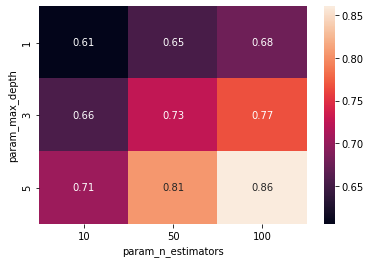

In [85]:
sns.heatmap(result_pivot,annot=True)

In [86]:
clf.best_params_

{'max_depth': 5, 'n_estimators': 100}

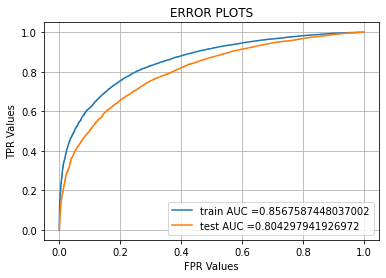

In [87]:
from sklearn.metrics import roc_curve, auc
DT_TFIDF = xgb.XGBClassifier(max_depth=5,n_estimators=100)
DT_TFIDF.fit(X_tr_TFIDF, y_train)
y_train_pred=batch_predict(DT_TFIDF, X_tr_TFIDF)
y_test_pred=batch_predict(DT_TFIDF, X_te_TFIDF)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, batch_predict(DT_TFIDF, X_tr_TFIDF))
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, batch_predict(DT_TFIDF, X_te_TFIDF))

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR Values")
plt.ylabel("TPR Values")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [88]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [89]:
def heatmap_cm(cm):
  ax= plt.subplot();
  sns.heatmap(cm, annot=True,cmap='Blues',ax=ax,fmt="d");
  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_ylim(2.0, 0)
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(['Fake','Real']); 
  ax.yaxis.set_ticklabels(['Fake','Real']);

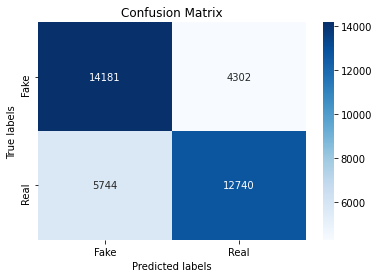

In [90]:
heatmap_cm(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

Finding Hyperparameter for SET-2(TFIDFW2V Vectorised) using RandomSearchCV.

In [91]:
parameters = {'max_depth':([1,3,5]),"n_estimators":([10, 50,100])}
clf = RandomizedSearchCV(xgb_model, parameters, cv=10, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr_TFIDFW2V, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
print(results)

   mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0      11.645354      0.237207  ...          0.605907         0.003839
1      30.469639      0.163166  ...          0.654491         0.000952
2      54.258697      0.344910  ...          0.677769         0.001001
3      20.798232      0.086057  ...          0.655793         0.002584
4      75.480398      0.243177  ...          0.726648         0.001202
5     143.830810      1.870726  ...          0.768194         0.001067
6      30.495720      0.063420  ...          0.704990         0.002000
7     122.288527      0.332323  ...          0.807265         0.001845
8     236.148390      1.652308  ...          0.861877         0.001440

[9 rows x 32 columns]


In [92]:
train_auc= results['mean_train_score']
cv_auc = results['mean_test_score'] 
max_depth=results["param_max_depth"]
n_estimators=results["param_n_estimators"]

In [93]:
result_pivot=results.pivot(index="param_max_depth",columns="param_n_estimators",values="mean_train_score")

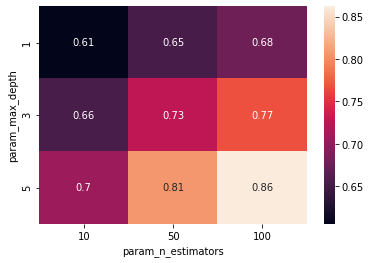

In [94]:
sns.heatmap(result_pivot,annot=True)

In [95]:
clf.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [96]:
DT_TFIDF_W2V = xgb.XGBClassifier(max_depth=5,n_estimators=100)
DT_TFIDF_W2V.fit(X_tr_TFIDFW2V, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

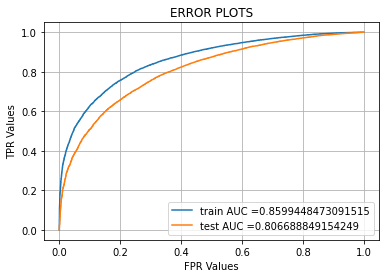

In [97]:
y_train_pred=batch_predict(DT_TFIDF_W2V, X_tr_TFIDFW2V)
y_test_pred=batch_predict(DT_TFIDF_W2V, X_te_TFIDFW2V)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, batch_predict(DT_TFIDF_W2V, X_tr_TFIDFW2V))
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, batch_predict(DT_TFIDF_W2V, X_te_TFIDFW2V))

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR Values")
plt.ylabel("TPR Values")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

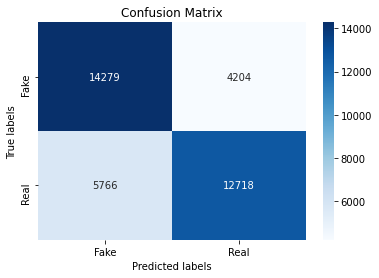

In [98]:
heatmap_cm(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

<h1>3. Summary</h1>

<br> 

In [99]:
pip install tabulate

In [100]:
from tabulate import tabulate

In [101]:
table = [['Vectorizer', 'Hyper parameter:max_depth','Hyper parameter:n_estimators',"AUC"], ['TFIDF', 5,100,0.804 ], ['TFIDFw2v',5,100, 0.806]]

In [102]:
print(tabulate(table, headers='firstrow', tablefmt='grid'))

+--------------+-----------------------------+--------------------------------+-------+
| Vectorizer   |   Hyper parameter:max_depth |   Hyper parameter:n_estimators |   AUC |
+==============+=============================+================================+=======+
| TFIDF        |                           5 |                            100 | 0.804 |
+--------------+-----------------------------+--------------------------------+-------+
| TFIDFw2v     |                           5 |                            100 | 0.806 |
+--------------+-----------------------------+--------------------------------+-------+
